# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

В директории содержится файл `labels.csv` с названиями файлов и возрастом, а также папка `final_files`, содержащая сами фотографии.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid') # Установка стиля для графиков

from tensorflow.keras.preprocessing.image import ImageDataGenerator 

## Исследовательский анализ данных

Для начала загрузим данные. Чтобы не запутаться в метках, проведем загрузку фотографий прямо по датасету с метками.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_flow = train_datagen.flow_from_dataframe( # Загрузка датагена по датафрейму
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345
)
labels.info()

Found 7591 validated image filenames.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


7591 объект, и ни одного пропуска. Посмотрим на распределение возраста в датасете, от него будет зависеть качество прогнозирования разных возрастов.

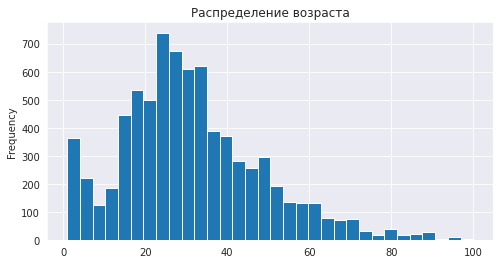

In [3]:
labels['real_age'].plot(kind='hist', bins=32, figsize=(8, 4), title='Распределение возраста');

Сравнительно немного фотографий людей в возрасте ~10 лет, а также крайне мало данных о людях старше 70-ти. Это может повлиять на качество прогнозов в этих промежутках.

Также возьмём небольшое количество фотографий на пробу, посмотрим какие именно фотографии у нас имеются, и проверим примерное качество разметки.

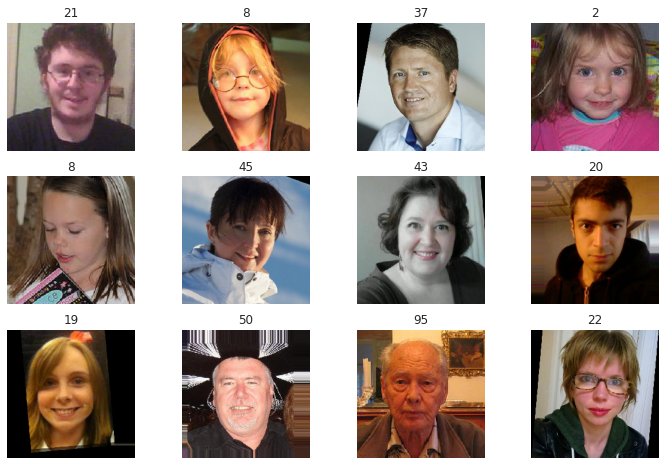

In [4]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i in range(12):
    ax = axes[i//4, i%4]
    ax.imshow(train_flow[4][0][i])
    ax.set_title(train_flow[4][1][i])
    ax.axis("off")
    ax.grid(False)

Метки возрастов похожи на правду, фотографии представлены в разных освещениях с разными фонами, но план всегда крупный, как раз тот, что будут видеть камеры. 

Судя по всему, данные вполне в пригодном состоянии, а раз отдельно подготавливать их не надо - приступим сразу к обучению модели.

## Обучение модели

Однако, обучать мы будем модель не простую, а золотую, конкретней - нейронную сеть. И, поскольку оборудование, которому такая задача по силам, судя по цене, тоже из золота, обучаться модель будет на сервере.

Чтобы обучение прошло корректно - составим 4 функции с фиксированными названиями и параметрами. Поскольку запуск этих функций будет происходить на сервере, над некоторыми моментами здесь мы не властны. Чтобы лучше контролировать ситуацию, и понимать на каком именно этапе находится обучение - каждую функцию снабдим выводом отладочных сообщений.

Используем стандартную архитектуру ResNet50 без верхушки, после неё добавим пулинг и слой dropout, чтобы избежать избыточного переобучения. Соберём все функции и отправим на сервер.

(Код в следующей ячейке запускается отдельно на сервере, поэтому оформлен в виде текста в markdown ячейке)

```python

from tensorflow import keras # Импорт необходимых для работы библиотек
import numpy as np
import pandas as pd

def load_train(path): 
# Загрузка тренировочных данных. Принимает на вход путь до целевой папки, возвращает готовый объект ImageDataGenerator
    print('train loading started')
    labels = pd.read_csv(path+'labels.csv') # Чтение датасета с метками
    print('dataframe loading completed')
    
    train_datagen = keras.preprocessing.image.ImageDataGenerator( # Создаём объект для чтения изображений
        validation_split=0.25, 
        rescale=1/255.)
    print('datagen creating completed')
    
    train_datagen_flow = train_datagen.flow_from_dataframe( 
        dataframe=labels, 
        directory=path+'/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
        
    print('train loading completed')
    return train_datagen_flow

def load_test(path):
    # Загрузка тестовых данных
    print('test loading started')
    labels = pd.read_csv(path+'labels.csv')
    
    test_datagen = keras.preprocessing.image.ImageDataGenerator(
        validation_split=0.25, 
        rescale=1/255.)
        
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
        
    print('test loading completed')
    return test_datagen_flow


def create_model(input_shape):
    # Создание модели. Принимает на вход размерность изображений, возвращает скомпилированную модель
    print('model creating started')
    backbone = keras.applications.resnet.ResNet50(
        input_shape=(input_shape), 
        include_top=False, 
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
        # Веса для слоя уже загружены на сервер. Используем их
    optimizer = keras.optimizers.Adam(learning_rate=.0002) # Устанавливаем lr для оптимизатора Adam
    
    model = keras.models.Sequential() # Инициализируем последовательную модель
    
    model.add(backbone) # Добавляем слои ResNet50
    model.add(keras.layers.GlobalAveragePooling2D())
    
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1, activation='relu'))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    # Компилируем модель. Функция потерь - средний квадрат ошибок, метрика для отслеживания - средний модуль ошибок
    
    print('model creating completed')
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):
    # Обучение модели. Принимает на вход скомпилированную модель с параметрами, возвращает обученную модель.
    print('model training started')
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    print('model training completed')
    return model 

```

Обучение заняло меньше получаса, для нейросети с более чем пятьюдесятью слоями это очень хороший результат. Теперь взглянем на то, как хорошо она обучилась. У нас было двадцать эпох, и на каждой модель старалась совершенствоваться, снижая значение функции потерь, которой у нас выступает средний квадрат ошибок. Правее от него находится средний модуль ошибки, а ещё провее те-же метрики на валидационных данных.

```

Using TensorFlow backend.
train loading started
dataframe loading completed
datagen creating completed
Found 5694 validated image filenames.
train loading completed
test loading started
Found 1897 validated image filenames.
test loading completed
model creating started
model creating completed
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
model training started
Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 61s - loss: 222.5363 - mean_absolute_error: 10.7279 - val_loss: 771.0961 - val_mean_absolute_error: 22.8464
Epoch 2/20
178/178 - 48s - loss: 73.8183 - mean_absolute_error: 6.5226 - val_loss: 640.2344 - val_mean_absolute_error: 20.1590
Epoch 3/20
178/178 - 46s - loss: 39.8707 - mean_absolute_error: 4.8615 - val_loss: 298.3520 - val_mean_absolute_error: 12.7244
Epoch 4/20
178/178 - 43s - loss: 28.5537 - mean_absolute_error: 4.1197 - val_loss: 132.6856 - val_mean_absolute_error: 8.5358
Epoch 5/20
178/178 - 43s - loss: 23.1426 - mean_absolute_error: 3.6726 - val_loss: 78.6837 - val_mean_absolute_error: 6.7075
Epoch 6/20
178/178 - 43s - loss: 18.1097 - mean_absolute_error: 3.2334 - val_loss: 74.9803 - val_mean_absolute_error: 6.7194
Epoch 7/20
178/178 - 43s - loss: 16.4205 - mean_absolute_error: 3.0933 - val_loss: 73.1018 - val_mean_absolute_error: 6.4901
Epoch 8/20
178/178 - 43s - loss: 14.0138 - mean_absolute_error: 2.8703 - val_loss: 77.7620 - val_mean_absolute_error: 6.7665
Epoch 9/20
178/178 - 43s - loss: 12.8154 - mean_absolute_error: 2.7232 - val_loss: 75.3241 - val_mean_absolute_error: 6.3937
Epoch 10/20
178/178 - 43s - loss: 11.6881 - mean_absolute_error: 2.6002 - val_loss: 79.4988 - val_mean_absolute_error: 7.0079
Epoch 11/20
178/178 - 43s - loss: 11.0473 - mean_absolute_error: 2.5024 - val_loss: 68.8763 - val_mean_absolute_error: 6.2605
Epoch 12/20
178/178 - 43s - loss: 11.3239 - mean_absolute_error: 2.5258 - val_loss: 74.2028 - val_mean_absolute_error: 6.4357
Epoch 13/20
178/178 - 44s - loss: 11.1510 - mean_absolute_error: 2.5101 - val_loss: 81.1623 - val_mean_absolute_error: 6.6115
Epoch 14/20
178/178 - 47s - loss: 10.7918 - mean_absolute_error: 2.4850 - val_loss: 77.5643 - val_mean_absolute_error: 6.8277
Epoch 15/20
178/178 - 50s - loss: 9.9251 - mean_absolute_error: 2.3812 - val_loss: 75.4434 - val_mean_absolute_error: 6.6795
Epoch 16/20
178/178 - 49s - loss: 9.2433 - mean_absolute_error: 2.3011 - val_loss: 65.7471 - val_mean_absolute_error: 6.0478
Epoch 17/20
178/178 - 47s - loss: 10.0666 - mean_absolute_error: 2.3814 - val_loss: 68.8076 - val_mean_absolute_error: 6.1239
Epoch 18/20
178/178 - 50s - loss: 10.5125 - mean_absolute_error: 2.4385 - val_loss: 68.0286 - val_mean_absolute_error: 6.1860
Epoch 19/20
178/178 - 49s - loss: 9.4641 - mean_absolute_error: 2.3448 - val_loss: 67.2777 - val_mean_absolute_error: 6.1592
Epoch 20/20
178/178 - 47s - loss: 9.5542 - mean_absolute_error: 2.3286 - val_loss: 71.8003 - val_mean_absolute_error: 6.3650
model training completed
60/60 - 12s - loss: 71.8003 - mean_absolute_error: 6.3650
Test MAE: 6.3650

```

Выглядит немного громоздко. Дальше займёмся более понятной интерпритацией.

## Анализ обученной модели

И так, перед нами стоит задача - провести анализ модели. Так как доступа ни к самой модели, ни к результатам предсказаний мы более не имеем по техническим причинам, воспользуемся имеющимися у нас данными - выводом в консоль о результатах обучения. Начнём с того, что попросим ChatGPT перевести результаты вывода в удобную для записи последовательность значений, и объединим всё в один датафрейм.

In [5]:
errors = pd.DataFrame({
    'mean_absolute_error':[10.7279, 6.5226, 4.8615, 4.1197, 3.6726, 3.2334, 3.0933, 2.8703, 2.7232, 2.6002, 2.5024, 2.5258, 2.5101, 2.4850, 2.3812, 2.3011, 2.3814, 2.4385, 2.3448, 2.3286],
    'val_mean_absolute_error':[22.8464, 20.1590, 12.7244, 8.5358, 6.7075, 6.7194, 6.4901, 6.7665, 6.3937, 7.0079, 6.2605, 6.4357, 6.6115, 6.8277, 6.6795, 6.0478, 6.1239, 6.1860, 6.1592, 6.3650],
    'loss':[222.5363, 73.8183, 39.8707, 28.5537, 23.1426, 18.1097, 16.4205, 14.0138, 12.8154, 11.6881, 11.0473, 11.3239, 11.1510, 10.7918, 9.9251, 9.2433, 10.0666, 10.5125, 9.4641, 9.5542],
    'val_loss':[771.0961, 640.2344, 298.3520, 132.6856, 78.6837, 74.9803, 73.1018, 77.7620, 75.3241, 79.4988, 68.8763, 74.2028, 81.1623, 77.5643, 75.4434, 65.7471, 68.8076, 68.0286, 67.2777, 71.8003]
})
# Эпохи нумеруются с 1 до 20, а базовый индекс с 0 до 19
errors['epoch'] = errors.index+1

Теперь отобразим графики изменения значений метрик по эпохам, сразу для тренировочной и валидационной выборки. Начнём с MAE.

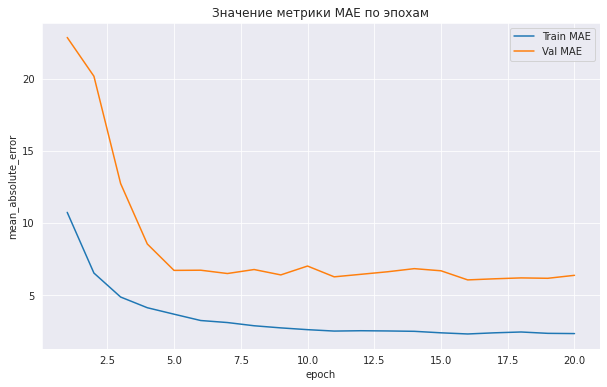

In [6]:
plt.figure(figsize=(10, 6))
plt.title('Значение метрики MAE по эпохам')
sns.lineplot(data=errors, x='epoch', y='mean_absolute_error', label='Train MAE')
sns.lineplot(data=errors, x='epoch', y='val_mean_absolute_error', label='Val MAE');

Значения ошибок на валидационных данных резко снижались до пятой эпохи. После начинаются незначительные колебания. При особой нехватке вычислительных мощностей обучение можно было-бы остановить и раньше. Значения MAE на тренировочных данных плавно снижались почти всё время обучения, остановившись на ~15 эпохе.

Ничего криминального или требующего срочного вмешательства. Посмотрим также на значения функции потерь, коей у нас выступал средний квадрат ошибки. 

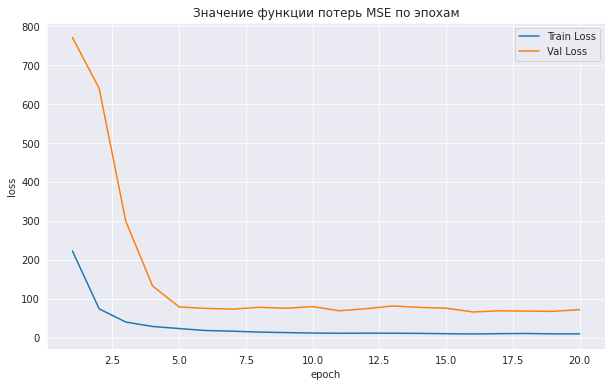

In [7]:
plt.figure(figsize=(10, 6))
plt.title('Значение функции потерь MSE по эпохам')
sns.lineplot(data=errors, x='epoch', y='loss', label='Train Loss')
sns.lineplot(data=errors, x='epoch', y='val_loss', label='Val Loss');

Знакомая картина, но в другом масштабе. Особенностью MSE является чувствительность к аномально высоким или аномально низким значениям. То, что мы не видим сильных различий между двумя графиками говорит о том, что модель не допускает крупных ошибок.

## Итоговый вывод

В рамках исследовательского анализа, мы:
- Загрузили данные при помощи объекта ImageDataGenerator для экономии оперативной памяти;
- Изучили распределение возрастов в выборке;
- Отобразили несколько фотографий, проверили примерное качество снимков и разметки.

В рамках обучения модели, мы:
- Составили функции загрузки данных, создания и обучения модели;
- Применили для нейросети стандартную архитектуру ResNet50 без верхушки;
- Обучили модель на удалённом сервере при помощи графического ускорителя и добились значения метрики MAE на тестовых данных не больше 8.

В рамках анализа модели, мы:
- Перевели полученные за время обучения значения метрик в датафрейм;
- Отобразили графики изменения метрик по эпохам обучения.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы